![logo](../img/LogoLine_horizon_C3S.png)

# Access and visualisation of the Greenland Ice Sheet velocity data
 
By J. Wuite, ENVEO IT GmbH, jan.wuite@enveo.at

## About

This tutorial will demonstrate how to plot velocity maps and flow vectors of the Greenland Ice Sheet and its major outlet glaciers, using ice velocity data from the Copernicus Climate Change Service (C3S). It will show you how to download data from the C3S Climate Data Store (CDS), plot the maps and and display flow vectors on top.

The dataset contains annual ice velocity maps of the Greenland Ice Sheet derived from Sentinel-1 SAR data. The data represent the current state-of-the-art in Europe for production of satellite-based ice velocity data records. It follows on from the ESA Greenland Ice Sheet Climate Change Initiative and is guided by the GCOS (Global Climate Observing System) targets for the Ice Sheets Essential Climate Variable.

Mapping glacier flow velocity and its temporal changes provides key information for investigating the dynamic response of glaciers and ice sheets to changing boundary environmental conditions. Remote sensing techniques that utilise satellite data are the only feasible manner to derive accurate surface velocities of the remote Greenland glaciers on a regular basis. 

More information on the dataset can be found here: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-greenland-ice-sheet-velocity?tab=overview

## Prepare your environment

To download data from the CDS, you must complete three steps;
1. Register for free with the CDS at https://cds.climate.copernicus.eu/#!/home
2. Set up the CDS Application Program Interface (API), as described at https://cds.climate.copernicus.eu/api-how-to
3. Agree to the dataset terms of use - if you have not already done so you will be directed to the correct webpage the first time you try to download data. Accept the terms and conditions, and re-run the downloading code.

## Import libraries

The data is stored in netCDF4 files. To work with them, several libraries are needed. These are used to retrieve the data, unpack it, run calculations and plot the results.

In [1]:
# CDS API
import cdsapi

# File handling
import shutil
import glob
import os

# Calculations
import numpy as np
import xarray as xr

# Mapping
import cartopy.crs as ccrs

# Plotting
import matplotlib.pyplot as plt

## Download data

Select the ice sheet of interest (currently only Greenland) and retrieve the dataset. An example of how to retrieve the data is given on the CDS, under 'Show API request' on the dataset's webpage at 
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-greenland-ice-sheet-velocity?tab=form

The dataset comes in a zip file, and may takesome time to load (>650 Mb). 

In [2]:
# Set ice_sheet to the desired ice sheet, either 'greenland' or 'antarctica' (not active yet) and select year/version
# This will be used to select data, and later to set up plot defaults. Ice velocity maps are extended on an annual basis, 
# in this example we use the time period 2020_2021, which extracts the annually averaged map for the 2020-2021 
# glaciological year (running from Oct 1st, 2020 - Sept 30th, 2021).

ice_sheet = 'greenland'
year = '2020_2021'
version = '1.4'

# Download data from the CDS
dataset='satellite-%s-ice-sheet-velocity' % ice_sheet

c = cdsapi.Client()

c.retrieve(
    dataset,
    {
        'period': year,
        'version': version,
        'variable': 'all',
        'format': 'zip',
    },
    'download.zip')

# Unpack the zip file and remove the zipped data

shutil.unpack_archive('download.zip', '.')
os.remove('download.zip')

# List the files contained and select the latest netCDF (.nc) file. Print its filename

list_of_files = glob.glob('*.nc') # * means all if need specific format then *.nc
latest_file = max(list_of_files, key=os.path.getctime)
print('In the following you are seeing the data from: \n'+latest_file)

In the following you are seeing the data from: 
C3S_GrIS_IV_250m_S1_20201001_20210930_v1_4.nc


## Examine the data

Open the data file and list its contents. These include descriptive comments. 

Data desciption: Ice velocity is provided at 250m and 500m grid spacing in North Polar Stereographic projection (depending on version). The horizontal velocity components are provided in true meters per day, towards the easting and northing directions of the grid. The vertical displacement is derived from a digital elevation model. Provided is a NetCDF file with the velocity components: vx, vy, vz, along with maps showing the magnitude of the horizontal components, the valid pixel count and uncertainty (based on the standard deviation). The product combines all ice velocity maps, based on 6- and 12-day repeats, acquired over a full year in an annually averaged product running from October 1st to September 30th, mimicking a glaciological year. The dataset is extended on an annual basis.

In [3]:
# Open the NetCDF file

ds = xr.open_dataset(latest_file)

# Print contents list

print('The data file contains the following:')
print(ds)


The data file contains the following:
<xarray.Dataset> Size: 2GB
Dimensions:                              (y: 10801, x: 5984)
Coordinates:
  * y                                    (y) float64 86kB -6.556e+05 ... -3.3...
  * x                                    (x) float64 48kB -6.399e+05 ... 8.55...
Data variables:
    crs                                  int32 4B ...
    land_ice_surface_easting_velocity    (y, x) float32 259MB ...
    land_ice_surface_northing_velocity   (y, x) float32 259MB ...
    land_ice_surface_vertical_velocity   (y, x) float32 259MB ...
    land_ice_surface_velocity_magnitude  (y, x) float32 259MB ...
    land_ice_surface_measurement_count   (y, x) float64 517MB ...
    land_ice_surface_easting_stddev      (y, x) float32 259MB ...
    land_ice_surface_northing_stddev     (y, x) float32 259MB ...
Attributes: (12/13)
    Conventions:    CF-1.7
    title:          Ice Velocity of the Greenland Ice Sheet
    reference:      Main: Nagler, T.; Rott, H.; Hetzenecker,

## Plot the Greenland Ice Sheet velocity map and display flowvectors on top

The following section plots the ice velocity map color coded in a figure in Polar Stereographic projection with a nice background. In addition it extracts the vx and vy components of the velocity from the dataset which are used to display velocity directions on top of the velocity map. In this way the figure does not only show the magnitude of the ice velocity but also the direction of ice flow.


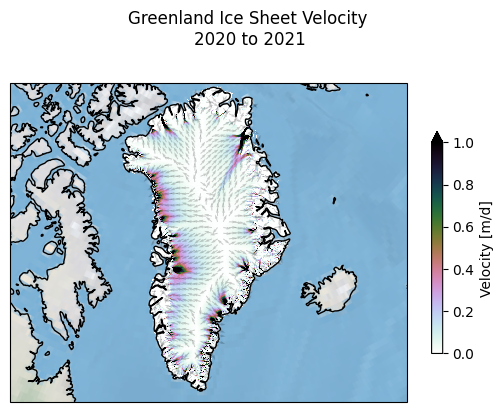

In [4]:
# Plot the ice velocity map in a figure in Polar Stereographic projection with a nice background, color map and vectors on top

#For Greenland:

projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) #EPSG:3413
ext = [-73, -12, 59, 83]    # map boundaries, in degrees, [east, west, south, north]
    
# Create a new figure

fig = plt.figure()
title='Greenland Ice Sheet Velocity \n'+year[0:4]+ ' to ' +year[5:9]
fig.suptitle(title, fontsize=12)

# Add a new subplot to the figure with the projection defined above


ax = plt.axes(projection=projection)

# Set the extent of the map to the longitude and latitude range defined above

ax.set_extent(ext, crs=ccrs.PlateCarree())

# Add a background image and coastlines to the map
ax.stock_img()
ax.coastlines(resolution='50m')

# Plot the velocity magnitude data on the map. Customise the plot settings.

vmin=0        # Values below this value will be set to the bottom of the colour range
vmax=1          # Values above this value will be set to the top of the colour range
cmap='cubehelix_r'      # Reversed cubehelix colortable 

ds.land_ice_surface_velocity_magnitude.plot(vmin=vmin, vmax=vmax, cmap=cmap,cbar_kwargs={'label': "Velocity [m/d]",'shrink': 0.6})

# Extract the easting and northing velocity and display a selection on top as flow vectors

u=ds.land_ice_surface_easting_velocity.values
v=ds.land_ice_surface_northing_velocity.values
y=ds.coords['y'].values
x=ds.coords['x'].values

X=[]
Y=[]
U=[]
V=[]

for yi in range(0, u.shape[0], 200):
  for xi in range(0, u.shape[1], 200):
    X.append(x[xi])
    Y.append(y[yi])
    # Normalize to display all vectors at same length:
    U1=u[yi][xi]
    V1=v[yi][xi]
    U.append(U1 / np.sqrt(U1**2 + V1**2)) 
    V.append(V1 / np.sqrt(U1**2 + V1**2))
    scale=50
    # For proportionate vector length comment the above section and uncomment the following instead:
    #U.append(u[yi][xi])
    #V.append(v[yi][xi])
    #scale=5
plt.quiver(X,Y,U,V,scale=scale,alpha=0.2,color="black")

# Display the plot

plt.show()

## Zoom into key outlet glaciers of the Greenland Ice Sheet

The following zooms into some of the biggest outlet glaciers of the Greenland Ice Sheet and plots the ice velocity in subplots using a different color code.



In [ ]:

projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) #EPSG:3413

extents = {
    #'Hagen Glacier': [-33, -27, 81, 81.6],
    'Helheim Glacier': [-40, -37, 66, 67],
    #'Illullip Sermia': [-56.5, -55, 74.2, 74.6],
    'Jakobshavn Isbræ': [-51, -46, 68.5, 70.5],
    'Kangerlussaq Glacier': [-36, -32, 68, 70],
    'Petermann Glacier': [-62, -55, 80, 81.5],
    'Rink Glacier': [-53, -47, 71, 72.5],
    #'Ryder Glacier': [-53, -47, 80.5, 82],
    'Zachariae Isstrom': [-30, -20, 78, 80]
} # map boundaries for ke glaciers, in degrees, [east, west, south, north]

title='Greenland Ice Sheet Velocity 2020-2021'
fig = plt.figure()
fig.suptitle(title, fontsize=12)
fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': projection})
axs = axs.flatten()

i=0
for x in extents:
  axs[i].set_extent(extents[x], crs=ccrs.PlateCarree())
  axs[i].stock_img()
  axs[i].coastlines(resolution='50m')
  ds.land_ice_surface_velocity_magnitude.plot(ax=axs[i],vmin=0, vmax=2, cmap='viridis', cbar_kwargs={'label': "m/d",'shrink': 0.6})
  axs[i].set_title(x)    
  i+=1

plt.show()


## Summary

This notebook downloads, extracts, visualises and explores the Greenland Ice Sheet annual gridded velocity data 
available from the Copernicus Climate Data Store. In particular it plots a color coded annually averaged ice 
velocity map of the ice sheet and displays flow vectors, indicating the direction of ice flow, on top. It also 
zooms into some of the biggest outlet glaciers of the Greenland Ice Sheet. 

Repeated ice velocity mapping can be used to detect gradual or abrupt changes in ice flow which might indicate a dynamical imbalance. Ice velocity is an important parameter for determining the mass discharge
of ice sheet and glaciers and used to estimate the current contribution to sea-level rise and 
freshwater flux into the oceans. Ice velocity data is also used in ice sheet models, that 
inform about physical processes causing changes and help predict the contribution to 
future sea level rise in response to climate change.
